# Titanic Space
https://www.kaggle.com/competitions/spaceship-titanic/overview/description

## Data description
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, 
- FoodCourt, 
- ShoppingMall, 
- Spa, 
- VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Content
* [Import necessary libraries](#imports)
* [Load source data](#load_data)
* [EDA](#eda)
* [Model](#model)

## Import necessary libraries<a class="anchor" id="imports"></a>

In [73]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

## Load source data<a class="anchor" id="load_data"></a>

In [4]:
data = pd.read_csv("data/data.csv")

In [5]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]])

In [8]:
X_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6519, 13), (2174, 13), (6519,), (2174,))

### Number of nulls

In [30]:
# Number of nulls
pd.DataFrame(X_train.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100).astype(float).round(1)

,missing_count,missing_pct
PassengerId,0.0,0.0
HomePlanet,147.0,2.3
CryoSleep,156.0,2.4
Cabin,141.0,2.2
Destination,143.0,2.2
Age,143.0,2.2
VIP,147.0,2.3
RoomService,132.0,2.0
FoodCourt,126.0,1.9
ShoppingMall,158.0,2.4


In [31]:
pd.DataFrame(X_train.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100) \
    .sum()['missing_pct'].astype(float).round(1)

26.4

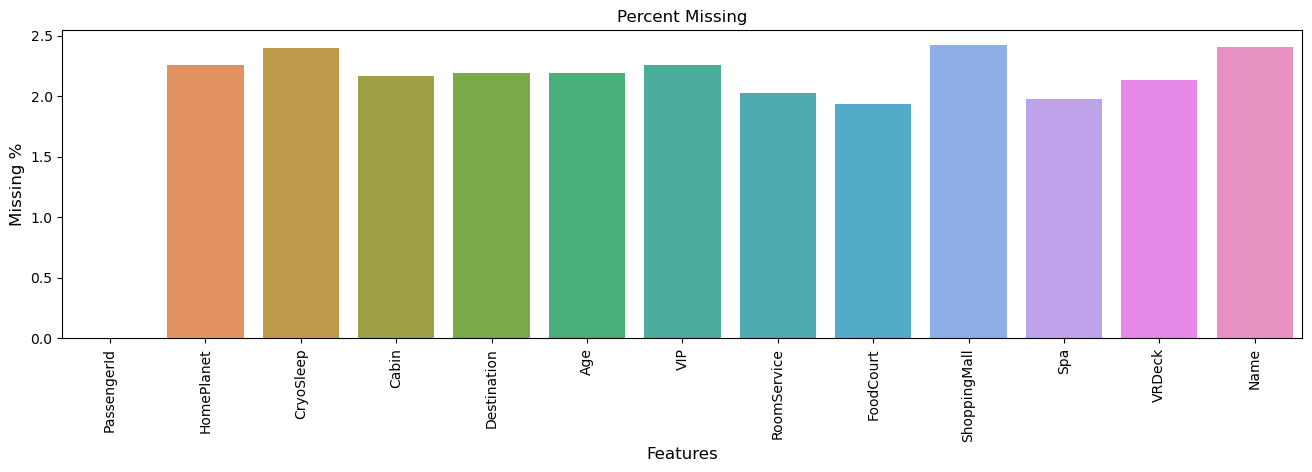

In [32]:
nan_train_X = ((X_train.isna().sum() / X_train.shape[0]*100)).reset_index()
nan_train_X.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(x=nan_train_X['feature'], y=nan_train_X['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing %', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

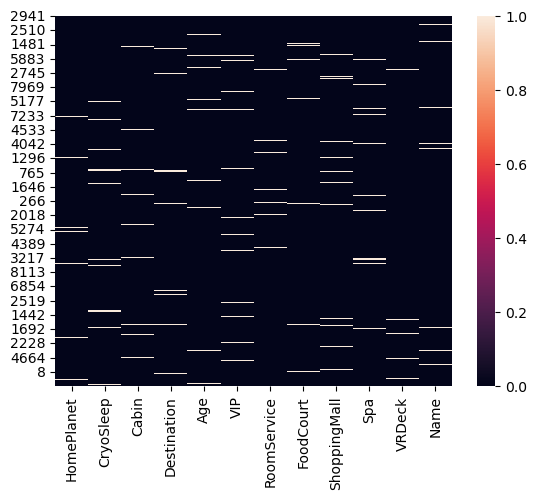

In [35]:
sns.heatmap(X_train[X_train.columns[1:]].isnull())
plt.show()

<Axes: >

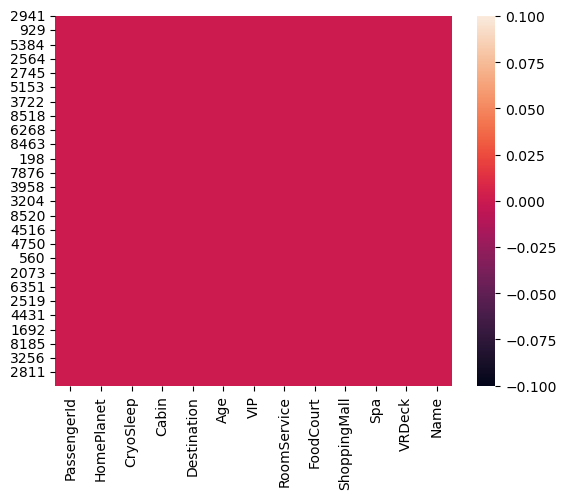

In [45]:
sns.heatmap(X_train.dropna().isnull())

In [47]:
X_train.shape, X_train.dropna().shape

((6519, 13), (4978, 13))

## EDA<a class="anchor" id="eda"></a>

In [ ]:
# TODO: For filling nan create model for each of features


In [48]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2941,3191_01,Mars,True,F/603/S,TRAPPIST-1e,68.0,False,0.0,0.0,0.0,0.0,0.0,Fex Sin
5641,5998_01,Earth,False,G/977/S,TRAPPIST-1e,30.0,False,477.0,0.0,8.0,0.0,323.0,Mara Haydenzier
8275,8836_01,Earth,False,F/1821/P,TRAPPIST-1e,26.0,False,903.0,0.0,182.0,0.0,27.0,Harlos Mcinton
7473,7995_01,Europa,True,NaN,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,Grum Stiviorad
4908,5234_01,Mars,False,F/1067/P,TRAPPIST-1e,16.0,False,271.0,0.0,2251.0,117.0,0.0,Tote Chmad


### PassangerID

In [49]:
#Find Group and No Pass
X_train[["G_Passenger", 'N_Passenger']] = X_train["PassengerId"].str.split('_', expand=True).astype('int')

#Set the Index
X_train.set_index('PassengerId',inplace=True)


X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,G_Passenger,N_Passenger
PassengerId,,,,,,,,,,,,,,
3191_01,Mars,True,F/603/S,TRAPPIST-1e,68.0,False,0.0,0.0,0.0,0.0,0.0,Fex Sin,3191,1
5998_01,Earth,False,G/977/S,TRAPPIST-1e,30.0,False,477.0,0.0,8.0,0.0,323.0,Mara Haydenzier,5998,1
8836_01,Earth,False,F/1821/P,TRAPPIST-1e,26.0,False,903.0,0.0,182.0,0.0,27.0,Harlos Mcinton,8836,1
7995_01,Europa,True,NaN,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,Grum Stiviorad,7995,1
5234_01,Mars,False,F/1067/P,TRAPPIST-1e,16.0,False,271.0,0.0,2251.0,117.0,0.0,Tote Chmad,5234,1


### Cabin

In [58]:
X_test[['Cabin']].shape

(2174, 1)

In [67]:
# Fill nan special values and split the field for three different fields

X_train['Cabin'].fillna('X/9999/X', inplace=True)
X_test['Cabin'].fillna('X/9999/X', inplace=True)

X_train.loc[:,['Cabin_1']] = X_train.Cabin.str.split("/",expand=True).iloc[:,0]
X_train.loc[:,['Cabin_2']] = X_train.Cabin.str.split("/",expand=True).iloc[:,1]
X_train.loc[:,['Cabin_3']] = X_train.Cabin.str.split("/",expand=True).iloc[:,2]

X_test.loc[:,['Cabin_1']] = X_test.Cabin.str.split("/",expand=True).iloc[:,0]
X_test.loc[:,['Cabin_2']] = X_test.Cabin.str.split("/",expand=True).iloc[:,1]
X_test.loc[:,['Cabin_3']] = X_test.Cabin.str.split("/",expand=True).iloc[:,2]

X_train.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)

### Destination

In [69]:
X_train['Destination'] = X_train['Destination'].fillna('Unknown')
X_test['Destination'] = X_test['Destination'].fillna('Unknown')


### HomePlanet

In [75]:
imp = SimpleImputer(strategy="most_frequent")

X_train['HomePlanet']=imp.fit_transform(X_train['HomePlanet'].to_numpy().reshape(-1,1))
# housing['total_bedrooms'] = imp.fit_transform(housing['total_bedrooms'].to_numpy().reshape(-1,1))
# X_test['HomePlanet']=imp.transform(X_test[['HomePlanet']])

ValueError: 2

### CryoSleep

In [ ]:
imp = SimpleImputer(strategy="most_frequent")

train_X['CryoSleep']=imp.fit_transform(train_X[['CryoSleep']])
test['CryoSleep']=imp.transform(test[['CryoSleep']])

### VIP

In [ ]:
imp = SimpleImputer(strategy="most_frequent")

train_X['VIP']=imp.fit_transform(train_X[['VIP']])
test['VIP']=imp.transform(test[['VIP']])

### Age

In [ ]:
imp = SimpleImputer(strategy="median")

train_X['Age']=imp.fit_transform(train_X[['Age']])
test['Age']=imp.transform(test[['Age']])

### RoomService

In [ ]:
#Fill Na with 0
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['RoomService']=imp.fit_transform(train_X[['RoomService']])
test['RoomService']=imp.transform(test[['RoomService']])

### FoodCourt

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['FoodCourt']=imp.fit_transform(train_X[['FoodCourt']])
test['FoodCourt']=imp.transform(test[['FoodCourt']])

### ShoppingMall

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['ShoppingMall']=imp.fit_transform(train_X[['ShoppingMall']])
test['ShoppingMall']=imp.transform(test[['ShoppingMall']])

### Spa

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['Spa']=imp.fit_transform(train_X[['Spa']])
test['Spa']=imp.transform(test[['Spa']])

### VRDeck

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['VRDeck']=imp.fit_transform(train_X[['VRDeck']])
test['VRDeck']=imp.transform(test[['VRDeck']])

### Name

In [ ]:
train_X.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

### Result EDA

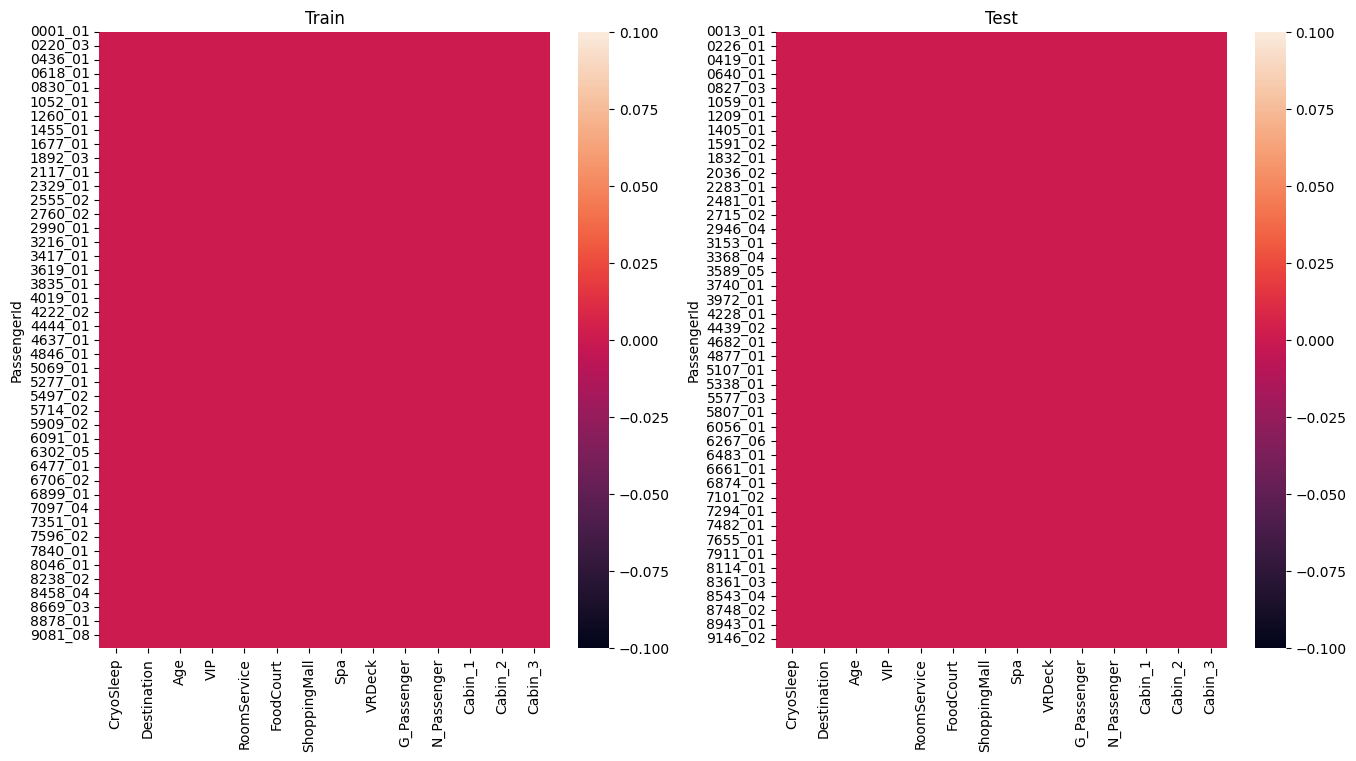

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.heatmap(train_X[train_X.columns[1:]].isnull())
ax.title.set_text('Train')

ax = fig.add_subplot(1, 2, 2)
ax = sns.heatmap(test[test.columns[1:]].isnull())
ax.title.set_text('Test')

plt.show()

### Feature engineering

In [ ]:
#Total Spend 
train_X['total_spent']= train_X['RoomService']+ train_X['FoodCourt']+ train_X['ShoppingMall']+ train_X['Spa']+ train_X['VRDeck']

In [ ]:
#Age Group Pass
train_X['AgeGroup'] = pd.cut(train_X.Age,bins=[0, 5, 12, 18, 50, 150], labels=['Baby','Child','Teen', 'Adult','Elderly'])
#Fill Value of NA
imp = SimpleImputer(strategy='constant', fill_value='Baby')
train_X['AgeGroup']=imp.fit_transform(train_X[['AgeGroup']])

In [ ]:
categorical_cols= ['HomePlanet','CryoSleep','Destination','VIP','Cabin_1','Cabin_3','Cabin_2','AgeGroup']
for i in categorical_cols:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate([train_X[i]], axis=0).astype(str)
    le.fit(arr)
    train_X[i]=le.transform(train_X[i].astype(str))

HomePlanet
CryoSleep
Destination
VIP
Cabin_1
Cabin_3
Cabin_2
AgeGroup


## Model<a class="anchor" id="model"></a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_y, test_size=0.2, random_state=13
)

In [ ]:
model=CatBoostClassifier(iterations=3000,
                         eval_metric='Accuracy',
                        verbose=0)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
pred=model.predict(X_test)

In [ ]:
pred[:5].astype('bool')

array([ True,  True,  True,  True,  True])

In [ ]:
y_test.values[:5]

array([ True,  True,  True,  True,  True])

In [ ]:

print(accuracy_score(y_test.values,pred.astype('bool')))

0.49396204715353653
